In [12]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tool.darknet2pytorch import Darknet
from tool.utils import *
from tool.torch_utils import *
import torch
from tqdm import tqdm  # Import tqdm for progress bar
import argparse

cfgfile = 'yolo-fish-2.cfg'
weightfile = 'merge_yolo-fish-2.weights'
csv_file = 'data/Localization.csv'
image_folder = 'data/images'
mask_folder = 'data/masks'
miss = 'mismatch_ids.txt'

In [17]:
m = Darknet(cfgfile)
m.load_weights(weightfile)
m.cuda()

def detect_fish_in_image(img, m, savename):
    """
    Function to detect fish in a given image using YOLO model.
    Returns the number of fish detected.
    """


    sized = cv2.resize(img, (m.width, m.height))
    sized = cv2.cvtColor(sized, cv2.COLOR_BGR2RGB)
        

    boxes = do_detect(m, sized, 0.4, 0.6, True)
    
    # Assuming that each box is a fish detection
    num_fish_detected = len(boxes[0])  # Each box is a fish detection
    plot_boxes_cv2(img, boxes[0], savename=savename, class_names=['fish'])

    return num_fish_detected

-----------------------------------
           Preprocess : 0.003998
      Model Inference : 0.388001
-----------------------------------
-----------------------------------
       max and argmax : 0.001001
                  nms : 0.000999
Post processing total : 0.002001
-----------------------------------
fish: 0.999059
fish: 0.997516
save plot results to res/0.jpg
Number of contours found: 1


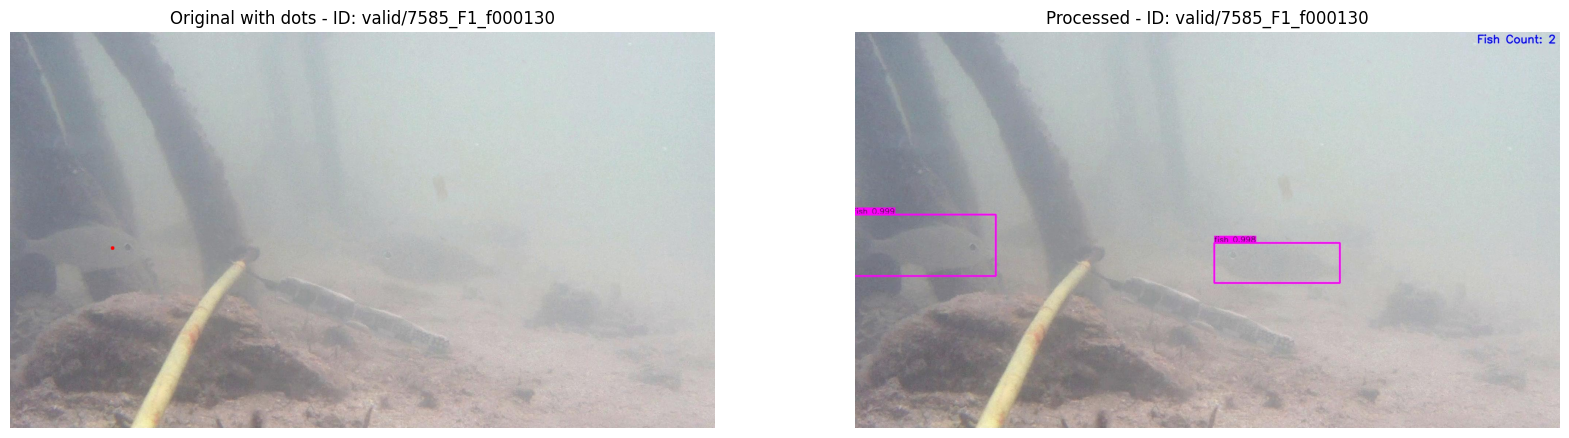

-----------------------------------
           Preprocess : 0.002001
      Model Inference : 0.102000
-----------------------------------
-----------------------------------
       max and argmax : 0.003002
                  nms : 0.000998
Post processing total : 0.004000
-----------------------------------
fish: 0.999833
fish: 0.998696
fish: 0.978423
save plot results to res/1.jpg
Number of contours found: 2


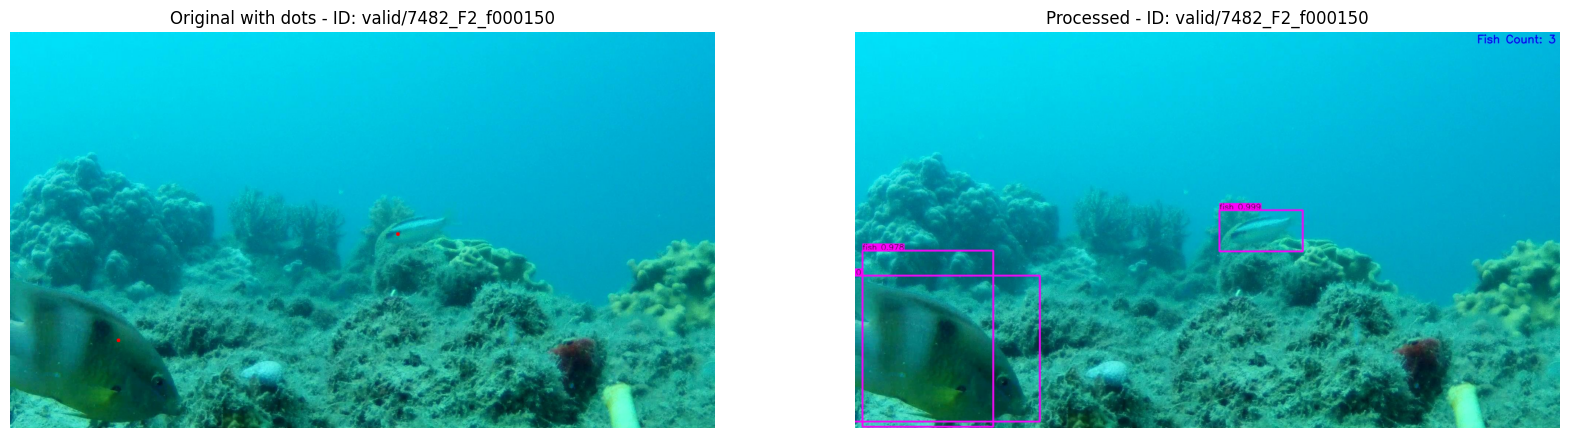

-----------------------------------
           Preprocess : 0.002968
      Model Inference : 0.099000
-----------------------------------
-----------------------------------
       max and argmax : 0.001999
                  nms : 0.000000
Post processing total : 0.001999
-----------------------------------
save plot results to res/2.jpg
Number of contours found: 1


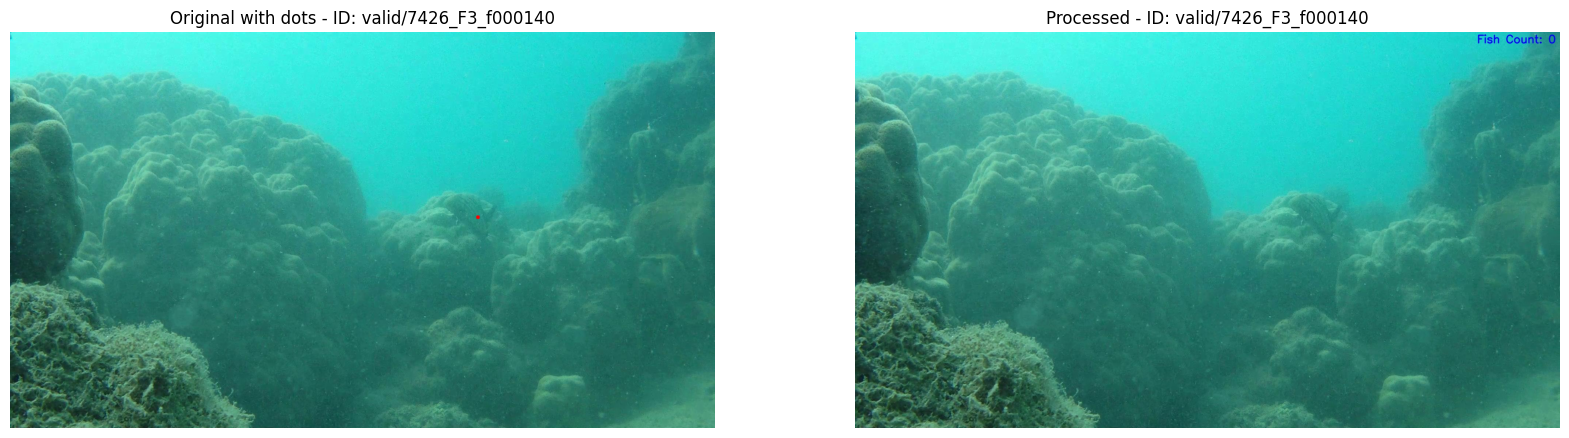

-----------------------------------
           Preprocess : 0.001971
      Model Inference : 0.099998
-----------------------------------
-----------------------------------
       max and argmax : 0.001000
                  nms : 0.000999
Post processing total : 0.002000
-----------------------------------
fish: 0.986561
save plot results to res/3.jpg
Number of contours found: 2


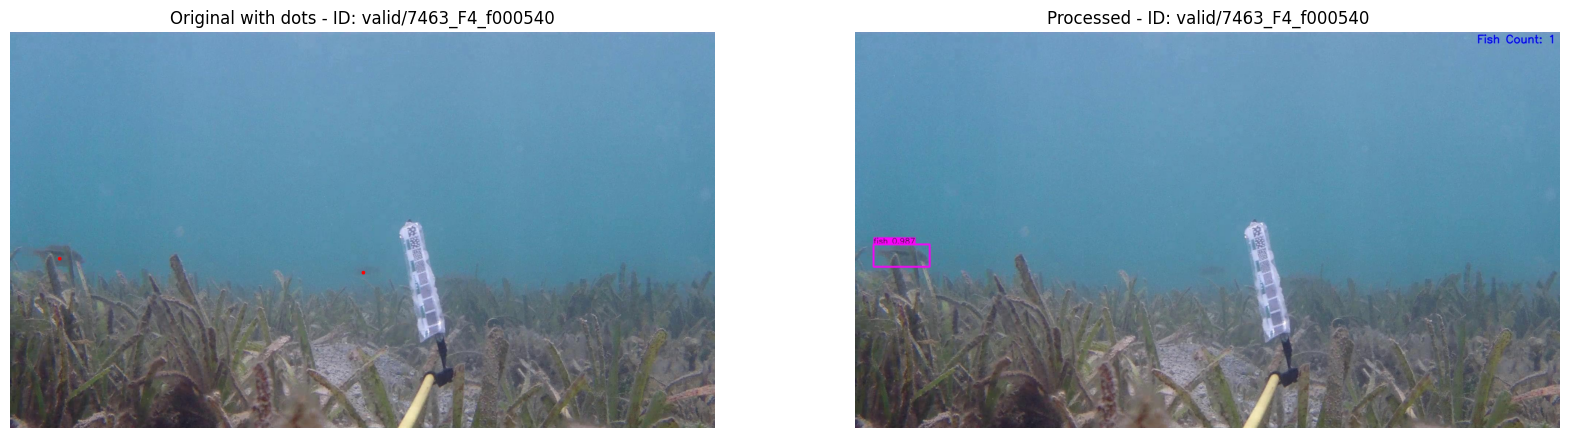

-----------------------------------
           Preprocess : 0.001965
      Model Inference : 0.097998
-----------------------------------
-----------------------------------
       max and argmax : 0.002000
                  nms : 0.000000
Post processing total : 0.002000
-----------------------------------
save plot results to res/4.jpg
Number of contours found: 2


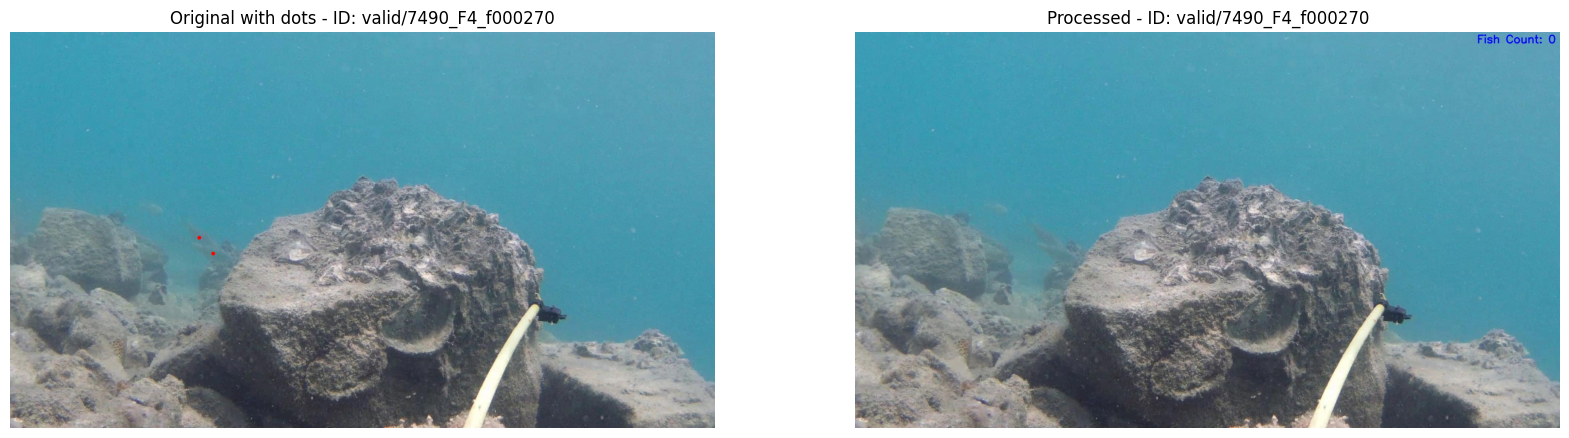

-----------------------------------
           Preprocess : 0.002997
      Model Inference : 0.101303
-----------------------------------
-----------------------------------
       max and argmax : 0.001985
                  nms : 0.000000
Post processing total : 0.001985
-----------------------------------
save plot results to res/5.jpg
Number of contours found: 2


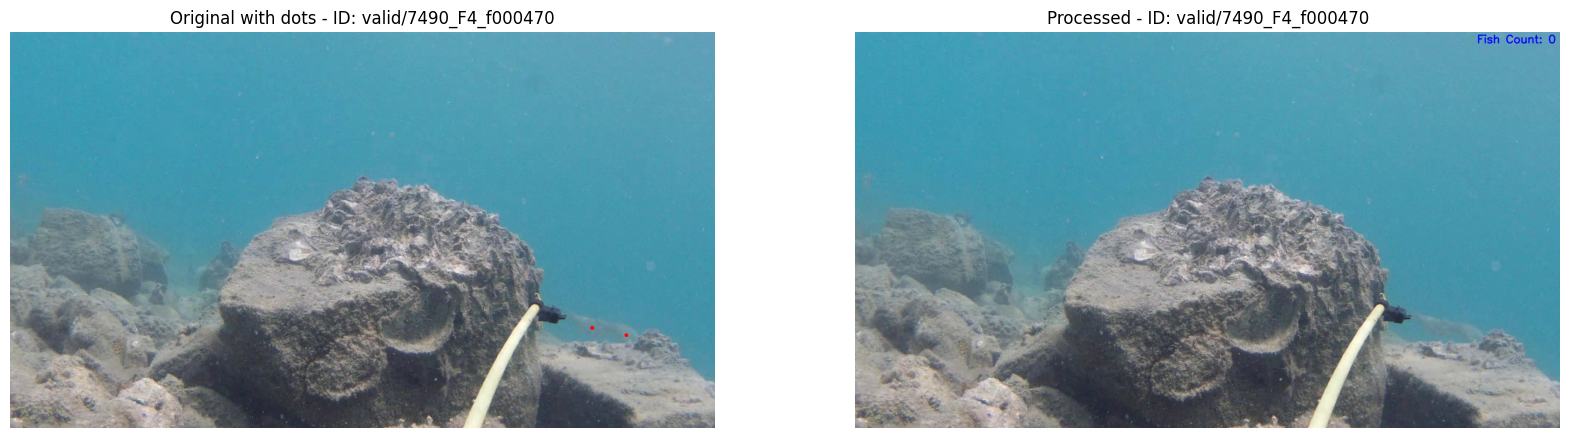

-----------------------------------
           Preprocess : 0.002965
      Model Inference : 0.099011
-----------------------------------
-----------------------------------
       max and argmax : 0.002988
                  nms : 0.001010
Post processing total : 0.003998
-----------------------------------
fish: 0.999749
fish: 0.998826
fish: 0.996818
fish: 0.995895
fish: 0.990969
fish: 0.958565
fish: 0.935555
fish: 0.853200
fish: 0.712472
save plot results to res/6.jpg
Number of contours found: 11


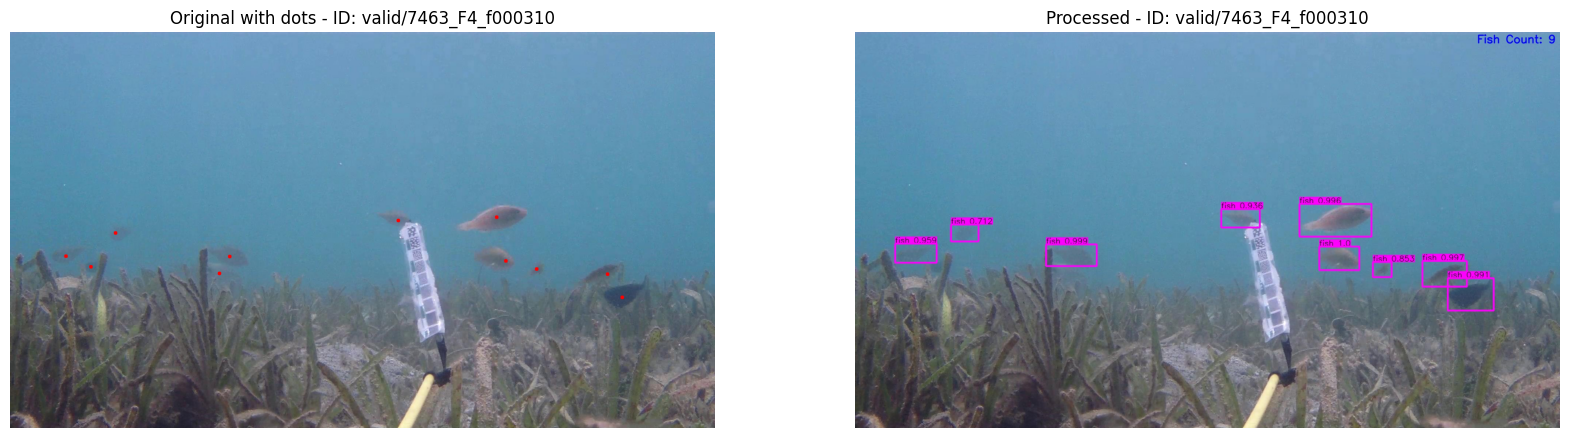

-----------------------------------
           Preprocess : 0.001969
      Model Inference : 0.099000
-----------------------------------
-----------------------------------
       max and argmax : 0.002000
                  nms : 0.000000
Post processing total : 0.002000
-----------------------------------
fish: 0.997711
save plot results to res/7.jpg
Number of contours found: 2


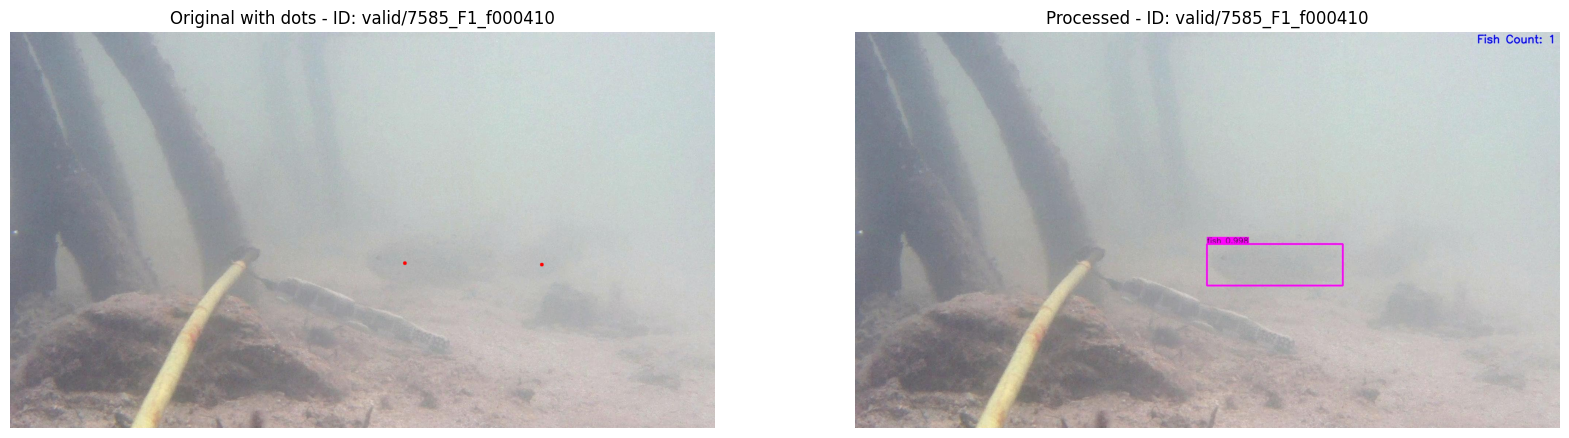

-----------------------------------
           Preprocess : 0.002999
      Model Inference : 0.099999
-----------------------------------
-----------------------------------
       max and argmax : 0.001999
                  nms : 0.000999
Post processing total : 0.002998
-----------------------------------
fish: 0.999781
fish: 0.998889
fish: 0.997477
fish: 0.993948
fish: 0.428514
save plot results to res/8.jpg
Number of contours found: 4


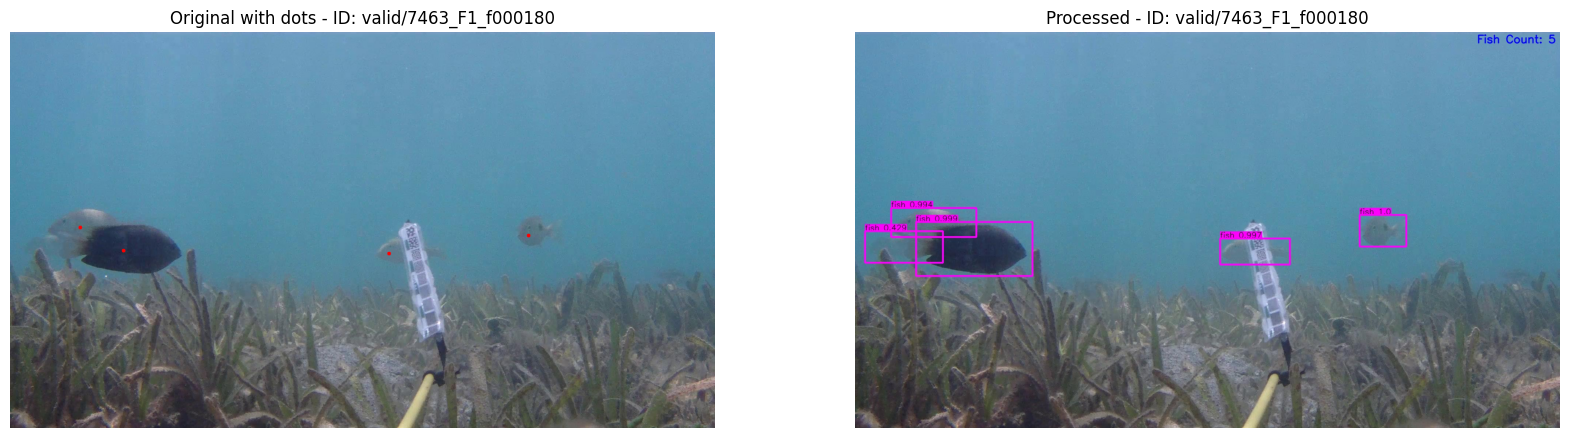

-----------------------------------
           Preprocess : 0.002970
      Model Inference : 0.098998
-----------------------------------
-----------------------------------
       max and argmax : 0.002999
                  nms : 0.000000
Post processing total : 0.002999
-----------------------------------
save plot results to res/9.jpg
Number of contours found: 1


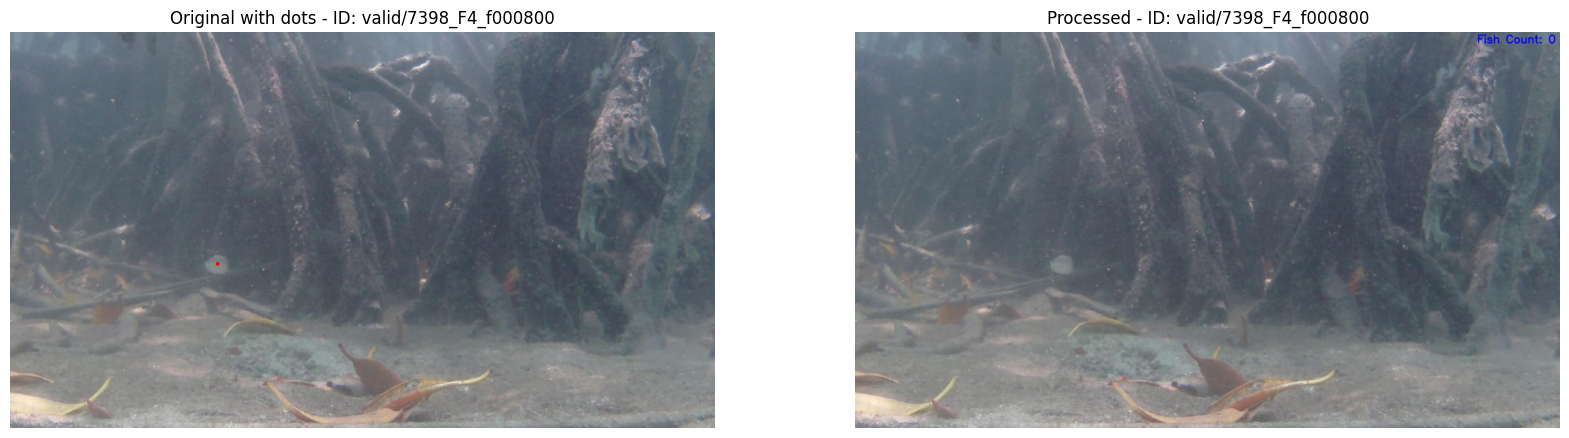

In [19]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt

# Read the mismatch IDs from the text file
with open(miss, 'r') as file:
    mismatch_ids = file.read().splitlines()

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file)

# Filter the DataFrame to include only rows with IDs in the mismatch_ids list
filtered_df = df[df['ID'].isin(mismatch_ids)]

# Select 10 random rows from the filtered DataFrame
random_images = filtered_df.sample(n=10)

# Display the images side by side
n = 0
for idx, row in random_images.iterrows():
    
    img_id = row['ID']
    img_path = os.path.join(image_folder, img_id + '.jpg')
    
    # Load original image
    img = cv2.imread(img_path)

    # Detect fish in the image and save to savename
    savename = f'res/{n}.jpg'
    detect_fish_in_image(img, m, savename)

    # Load the mask image and detect contours
    mask_path = os.path.join(mask_folder, img_id + '.png')
    mask = cv2.imread(mask_path)
    
    # Convert mask to grayscale
    gray_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    
    # Find contours in the mask
    contours, _ = cv2.findContours(gray_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Number of contours found: {len(contours)}")
    
    # Draw red circles on the original image at the locations of the white dots in the mask
    img_with_dots = img.copy()  # Create a copy of the original image
    for contour in contours:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        radius = int(radius) + 5  # Make the circle bigger
        cv2.circle(img_with_dots, center, radius, (0, 0, 255), -1)  # Draw a filled red circle

    # Load the processed savename image
    processed_img = cv2.imread(savename)

    # Display original image with dots and the processed image side by side
    plt.figure(figsize=(20, 15))

    # Plot the original image with the red dots
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img_with_dots, cv2.COLOR_BGR2RGB))
    plt.title(f"Original with dots - ID: {row['ID']}")
    plt.axis('off')

    # Plot the processed (savename) image
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Processed - ID: {row['ID']}")
    plt.axis('off')

    # Show the side-by-side comparison
    plt.show()

    n += 1
